In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
from tensorflow.keras import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [ ]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


In [ ]:
#Load data from .mat files
data98 = scipy.io.loadmat('/content/drive/MyDrive/mini_project_2/98.mat.txt')
data106 = scipy.io.loadmat('/content/drive/MyDrive/mini_project_2/106.mat.txt')
data119= scipy.io.loadmat('/content/drive/MyDrive/mini_project_2/119.mat.txt')
data131= scipy.io.loadmat('/content/drive/MyDrive/mini_project_2/131.mat.txt')
print(data98.keys())
print(data106.keys())
print(data119.keys())
print(data131.keys())


dict_keys(['__header__', '__version__', '__globals__', 'X098_DE_time', 'X098_FE_time'])
dict_keys(['__header__', '__version__', '__globals__', 'X106_DE_time', 'X106_FE_time', 'X106_BA_time', 'X106RPM'])
dict_keys(['__header__', '__version__', '__globals__', 'X119_DE_time', 'X119_FE_time', 'X119_BA_time', 'X119RPM'])
dict_keys(['__header__', '__version__', '__globals__', 'X131_DE_time', 'X131_FE_time', 'X131_BA_time', 'X131RPM'])


In [ ]:
normal = data98['X098_DE_time']
fault_Inner = data106['X106_DE_time']
fault_Ball=data119['X119_DE_time']
fault_Centered=data131['X131_DE_time']
print(f'number of data in X098_DE_time(normal) :{normal.size}')
print(f'number of data in X106_DE_time(fault) :{fault_Inner.size}')
print(f'number of data in X098_DE_time(normal) :{fault_Ball.size}')
print(f'number of data in X098_DE_time(normal) :{fault_Centered.size}')


number of data in X098_DE_time(normal) :483903
number of data in X106_DE_time(fault) :121991
number of data in X098_DE_time(normal) :121410
number of data in X098_DE_time(normal) :122426


In [ ]:
#Construct a matrix for each data sample
N = 700
M = 100
C1 = np.array([normal[N * i:N * (i + 1)] for i in range(M)]).reshape(N, M)
C2 = np.array([fault_Inner[N * i:N * (i + 1)] for i in range(M)]).reshape(N, M)
C3 = np.array([fault_Ball[N * i:N * (i + 1)] for i in range(M)]).reshape(N, M)
C4 = np.array([fault_Centered[N * i:N * (i + 1)] for i in range(M)]).reshape(N, M)

print(C1.shape)
print(C2.shape)
print(C3.shape)
print(C4.shape)


(700, 100)
(700, 100)
(700, 100)
(700, 100)


In [ ]:
X = np.vstack((C1, C2, C3, C4))
X.shape

(2800, 100)

In [ ]:
# Feature Extraction
data_std = np.std(X, axis=1, keepdims=True)
data_rms = np.sqrt(np.mean(np.square(X), axis=1)).reshape(-1, 1)
data_skewness= np.mean(((X - np.mean(X, axis=1, keepdims=True)) ** 3) / (np.std(X, axis=1, keepdims=True) ** 3), axis=1).reshape(-1, 1)
data_peak=np.max(np.abs(X), axis=1).reshape(-1, 1)
data_crest_factor=np.max(np.abs(X), axis=1).reshape(-1, 1) / np.sqrt(np.mean(np.square(X), axis=1)).reshape(-1, 1)
data_absolute_mean=np.mean(np.abs(X), axis=1).reshape(-1, 1)
data_impact_factor = np.max(np.abs(X), axis=1).reshape(-1, 1) / np.mean(np.abs(X), axis=1).reshape(-1, 1)
data_square_mean_root = np.square(np.mean(np.sqrt(np.abs(X)), axis=1)).reshape(-1, 1)

X_new = np.hstack([data_std, data_rms,data_skewness,data_peak,data_crest_factor,data_absolute_mean,data_impact_factor,data_square_mean_root])


In [ ]:
ones_array = np.ones((N, 1))
y = np.vstack((1*ones_array, 2 * ones_array, 3 * ones_array, 4 * ones_array))
y.shape

(2800, 1)

In [ ]:
# Function to split the data
def data_split(X, per):
    limit = int(len(X) * per)
    idx = np.random.permutation(len(X))
    return idx[:limit], idx[limit:]

# Splitting the data
d_train = 0.8
i_train1, i_test1 = data_split(X_new[:N], d_train)
i_train2, i_test2 = data_split(X_new[N:2*N], d_train)
i_train3, i_test3 = data_split(X_new[2*N:3*N], d_train)
i_train4, i_test4 = data_split(X_new[3*N:], d_train)


In [ ]:
print(i_train1.shape,i_test1.shape)
print(i_train2.shape,i_test2.shape)
print(i_train3.shape,i_test3.shape)
print(i_train4.shape,i_test4.shape)


(560,) (140,)
(560,) (140,)
(560,) (140,)
(560,) (140,)


In [ ]:
C1_train, C1_test = X_new[:N][i_train1], X_new[:N][i_test1]
C2_train, C2_test = X_new[N:2*N][i_train2], X_new[N:2*N][i_test2]
C3_train, C3_test = X_new[2*N:3*N][i_train3], X_new[2*N:3*N][i_test3]
C4_train, C4_test = X_new[3*N:][i_train4], X_new[3*N:][i_test4]

X_train = np.vstack((C1_train, C2_train, C3_train, C4_train))
y_train = np.vstack((1 * np.ones((len(C1_train), 1)),
                     2 * np.ones((len(C2_train), 1)),
                     3 * np.ones((len(C3_train), 1)),
                     4 * np.ones((len(C4_train), 1))))
X_test = np.vstack((C1_test, C2_test, C3_test, C4_test))
y_test = np.vstack((1 * np.ones((len(C1_test), 1)),
                    2 * np.ones((len(C2_test), 1)),
                    3 * np.ones((len(C3_test), 1)),
                    4 * np.ones((len(C4_test), 1))))

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)


X_train shape:  (2240, 8)
y_train shape:  (2240, 1)
X_test shape:  (560, 8)
y_test shape:  (560, 1)


In [ ]:
unique_values, counts = np.unique(y_train, return_counts=True)
unique_values,counts,y_train.shape

(array([1., 2., 3., 4.]), array([560, 560, 560, 560]), (2240, 1))

In [ ]:
unique_values, counts = np.unique(y_test, return_counts=True)
unique_values,counts,y_test.shape

(array([1., 2., 3., 4.]), array([140, 140, 140, 140]), (560, 1))

In [ ]:
train_df = pd.DataFrame(np.hstack((X_train, y_train.reshape(-1, 1))), columns=[f'Feature {i+1}' for i in range(X_train.shape[1])] + ['Label'])
test_df = pd.DataFrame(np.hstack((X_test, y_test.reshape(-1, 1))), columns=[f'Feature {i+1}' for i in range(X_test.shape[1])] + ['Label'])

train_df.to_csv('/content/drive/MyDrive/mini_project_2/dataset/train_data.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/mini_project_2/dataset/test_data.csv', index=False)



In [ ]:

df_train = pd.read_csv('/content/drive/MyDrive/mini_project_2/dataset/train_data.csv')
df_test = pd.read_csv('/content/drive/MyDrive/mini_project_2/dataset/test_data.csv')


In [ ]:
df_test.head(10)


,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Label
0,0.043847,0.048197,-0.155239,0.105977,2.198842,0.039856,2.658990,0.034401,1.0
1,0.047049,0.047924,-0.624390,0.134974,2.816429,0.039637,3.405263,0.034620,1.0
2,0.085472,0.087163,-0.399758,0.168770,1.936255,0.074282,2.272025,0.065560,1.0
3,0.069555,0.071373,-0.257590,0.130176,1.823892,0.062875,2.070407,0.057408,1.0
4,0.077764,0.077764,0.163456,0.168144,2.162223,0.064913,2.590307,0.057282,1.0
5,0.051886,0.052257,0.488988,0.123292,2.359328,0.042610,2.893513,0.036550,1.0
6,0.073514,0.079604,-0.338560,0.201940,2.536806,0.066081,3.055941,0.057757,1.0
7,0.054757,0.055422,-0.078523,0.148951,2.687572,0.046246,3.220859,0.040680,1.0
8,0.084882,0.084899,-0.145496,0.184416,2.172177,0.072045,2.559722,0.063861,1.0
9,0.069194,0.069243,-0.529188,0.160634,2.319851,0.056921,2.822063,0.049502,1.0


In [ ]:
df_train.head(10)

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Label
0,0.057043,0.064011,0.106907,0.159591,2.493184,0.052025,3.067608,0.044270,1.0
1,0.065114,0.065713,-1.098879,0.219463,3.339712,0.052016,4.219139,0.044550,1.0
2,0.066496,0.068943,0.259538,0.168561,2.444933,0.057855,2.913497,0.050336,1.0
3,0.072482,0.073485,-0.392406,0.175028,2.381809,0.061542,2.844068,0.053938,1.0
4,0.083946,0.084183,-0.256935,0.176489,2.096485,0.071407,2.471588,0.063017,1.0
5,0.059803,0.062304,-0.013894,0.146031,2.343832,0.050777,2.875924,0.043538,1.0
6,0.044036,0.044813,-0.234829,0.100761,2.248484,0.036387,2.769178,0.030498,1.0
7,0.055211,0.056452,-0.565488,0.154167,2.730947,0.045497,3.388509,0.039041,1.0
8,0.053812,0.063876,-0.413958,0.138312,2.165318,0.054013,2.560735,0.047357,1.0
9,0.055768,0.057494,0.222432,0.147491,2.565335,0.045904,3.213052,0.038192,1.0


In [ ]:
df_test.columns = ['data_std', 'data_rms', 'data_skewness', 'data_peak', 'data_crest_factor', 'data_absolute_mean','data_impact_factor','data_square_mean_root', 'label']
df_train.columns = ['data_std', 'data_rms', 'data_skewness', 'data_peak', 'data_crest_factor', 'data_absolute_mean','data_impact_factor','data_square_mean_root', 'label']


In [ ]:
df_test.head(10)

,data_std,data_rms,data_skewness,data_peak,data_crest_factor,data_absolute_mean,data_impact_factor,data_square_mean_root,label
0,0.043847,0.048197,-0.155239,0.105977,2.198842,0.039856,2.658990,0.034401,1.0
1,0.047049,0.047924,-0.624390,0.134974,2.816429,0.039637,3.405263,0.034620,1.0
2,0.085472,0.087163,-0.399758,0.168770,1.936255,0.074282,2.272025,0.065560,1.0
3,0.069555,0.071373,-0.257590,0.130176,1.823892,0.062875,2.070407,0.057408,1.0
4,0.077764,0.077764,0.163456,0.168144,2.162223,0.064913,2.590307,0.057282,1.0
5,0.051886,0.052257,0.488988,0.123292,2.359328,0.042610,2.893513,0.036550,1.0
6,0.073514,0.079604,-0.338560,0.201940,2.536806,0.066081,3.055941,0.057757,1.0
7,0.054757,0.055422,-0.078523,0.148951,2.687572,0.046246,3.220859,0.040680,1.0
8,0.084882,0.084899,-0.145496,0.184416,2.172177,0.072045,2.559722,0.063861,1.0
9,0.069194,0.069243,-0.529188,0.160634,2.319851,0.056921,2.822063,0.049502,1.0


In [ ]:
df_train.head(10)

,data_std,data_rms,data_skewness,data_peak,data_crest_factor,data_absolute_mean,data_impact_factor,data_square_mean_root,label
0,0.057043,0.064011,0.106907,0.159591,2.493184,0.052025,3.067608,0.044270,1.0
1,0.065114,0.065713,-1.098879,0.219463,3.339712,0.052016,4.219139,0.044550,1.0
2,0.066496,0.068943,0.259538,0.168561,2.444933,0.057855,2.913497,0.050336,1.0
3,0.072482,0.073485,-0.392406,0.175028,2.381809,0.061542,2.844068,0.053938,1.0
4,0.083946,0.084183,-0.256935,0.176489,2.096485,0.071407,2.471588,0.063017,1.0
5,0.059803,0.062304,-0.013894,0.146031,2.343832,0.050777,2.875924,0.043538,1.0
6,0.044036,0.044813,-0.234829,0.100761,2.248484,0.036387,2.769178,0.030498,1.0
7,0.055211,0.056452,-0.565488,0.154167,2.730947,0.045497,3.388509,0.039041,1.0
8,0.053812,0.063876,-0.413958,0.138312,2.165318,0.054013,2.560735,0.047357,1.0
9,0.055768,0.057494,0.222432,0.147491,2.565335,0.045904,3.213052,0.038192,1.0


In [ ]:
def extract_features_labels(df, feature_cols, label_col):
    X = df[feature_cols].values
    y = df[[label_col]].values
    return X, y

features = ['data_std', 'data_rms', 'data_skewness', 'data_peak', 'data_crest_factor',
            'data_absolute_mean', 'data_impact_factor', 'data_square_mean_root']
label = 'label'

x_train, y_train = extract_features_labels(df_train, features, label)
x_test, y_test = extract_features_labels(df_test, features, label)

# چاپ ابعاد مجموعه‌های داده
print(f'X_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (2240, 8)
y_train shape: (2240, 1)
X_test shape: (560, 8)
y_test shape: (560, 1)


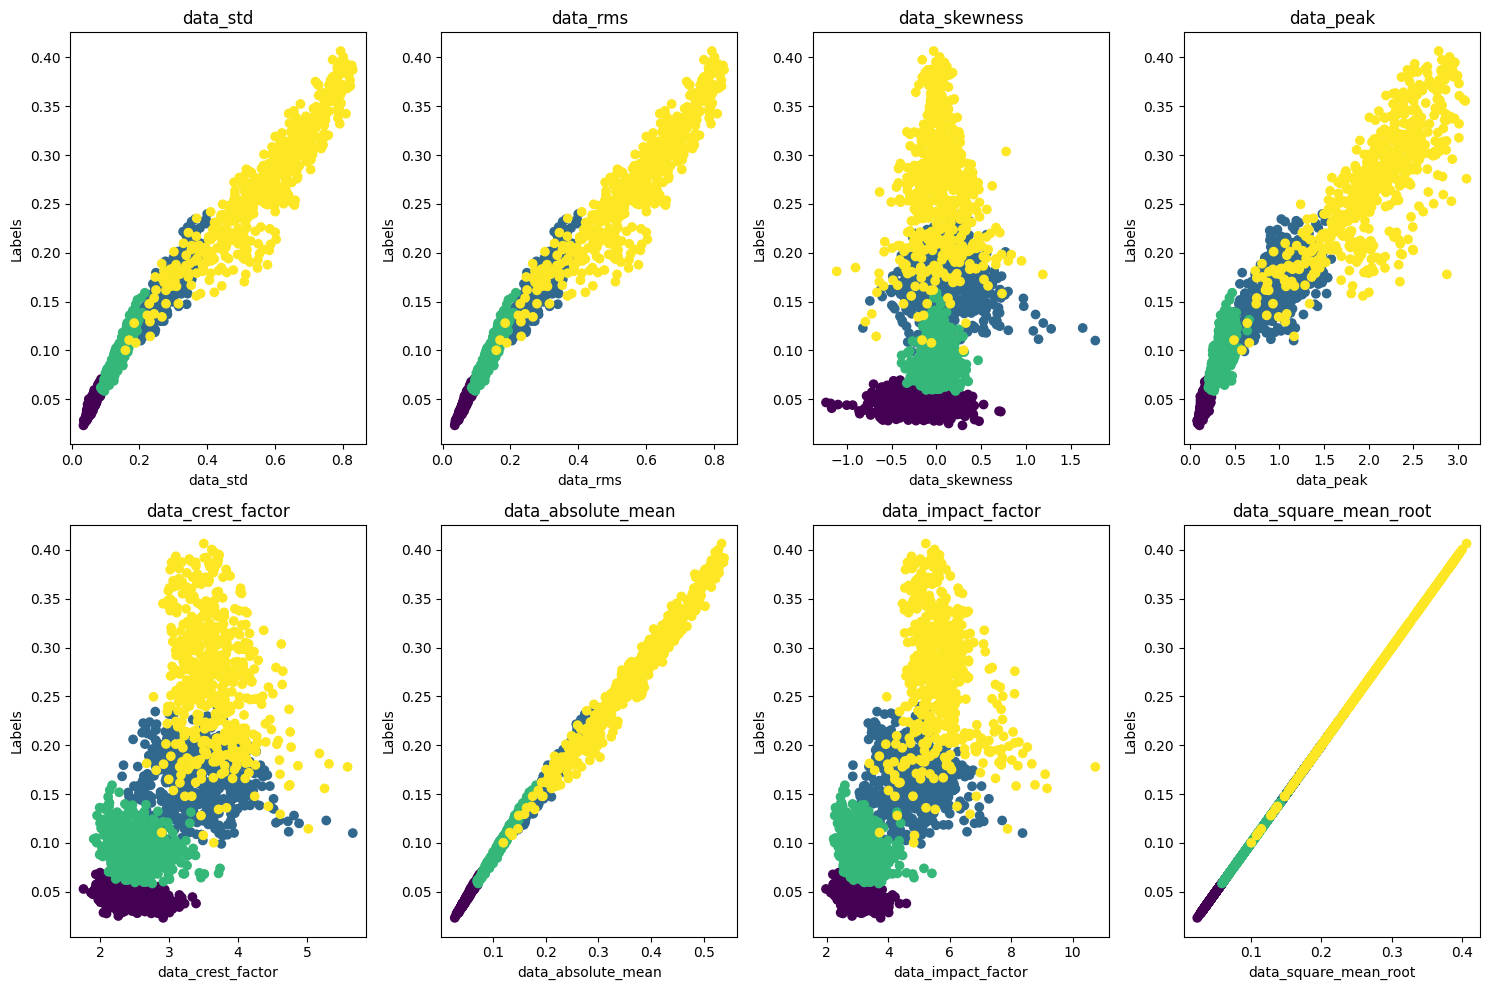

In [ ]:
import matplotlib.pyplot as plt

# Set up a figure and array of subplots with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(15, 10))

# Flatten the array of axes to make it easier to iterate over
axs = axs.flatten()

# Feature names (replace with actual feature names)
feature_names =  ['data_std', 'data_rms', 'data_skewness', 'data_peak', 'data_crest_factor',
            'data_absolute_mean', 'data_impact_factor', 'data_square_mean_root']

for i in range(8):
    axs[i].scatter(x_train[:, i], x_train[:, -1], c=y_train.ravel())
    axs[i].set_title(f'{feature_names[i]}')
    axs[i].set_xlabel(f'{feature_names[i]}')
    axs[i].set_ylabel('Labels')
plt.tight_layout()
plt.show()


In [ ]:
#combine test data and train data
X_combined = np.vstack((x_train, x_test))
y_combined = np.vstack((y_train, y_test))


In [ ]:
# Initial split into train and test sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined,test_size=0.2,
                                                                              stratify=y_combined, random_state=4, shuffle=True
)


# Split the training data for validation
X_train_combined,X_valid,y_train_combined,y_valid= train_test_split(X_train_combined, y_train_combined, test_size=0.2,
                                                                              stratify=y_train_combined, random_state=4, shuffle=True
)



print("Train set shape:", X_train_combined.shape)
print("Validation set shape:", X_valid.shape)
print("Test set shape:", X_test_combined.shape)


Train set shape: (1792, 8)
Validation set shape: (448, 8)
Test set shape: (560, 8)


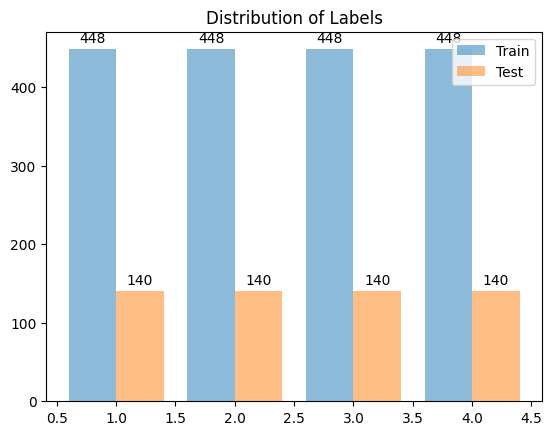

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# فرض کنید 'y_train_combined' و 'y_test_combined' لیبل‌های شما هستند
# محاسبه توزیع لیبل‌ها در مجموعه آموزشی و تست
labels, counts_train = np.unique(y_train_combined, return_counts=True)
_, counts_test = np.unique(y_test_combined, return_counts=True)

# نمایش توزیع لیبل‌ها
fig, ax = plt.subplots()
train_bar = ax.bar(labels - 0.2, counts_train, width=0.4, alpha=0.5, label='Train')
test_bar = ax.bar(labels + 0.2, counts_test, width=0.4, alpha=0.5, label='Test')

ax.legend()
ax.set_title('Distribution of Labels')

# افزودن تعداد داده‌ها برای هر کلاس روی نمودار
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(train_bar)
add_labels(test_bar)

plt.show()


In [ ]:
number_of_features = X_train_combined.shape[1]

feature_names = ['feature' + str(i+1) for i in range(number_of_features)]

train_data = pd.DataFrame(np.hstack((X_train_combined, y_train_combined.reshape(-1, 1))), columns=feature_names + ['label'])
train_data.to_csv('/content/drive/MyDrive/mini_project_2/dataset/train_data_model.csv', index=False)

test_data = pd.DataFrame(np.hstack((X_test_combined, y_test_combined.reshape(-1, 1))), columns=feature_names + ['label'])
test_data.to_csv('/content/drive/MyDrive/mini_project_2/dataset/test_data_model.csv', index=False)

valid_data = pd.DataFrame(np.hstack((X_valid, y_valid.reshape(-1, 1))), columns=feature_names + ['label'])
valid_data.to_csv('/content/drive/MyDrive/mini_project_2/dataset/valid_data_model.csv', index=False)


سوال دوم قسمت دوم

In [ ]:
import pandas as pd

train_data = pd.read_csv('/content/drive/MyDrive/mini_project_2/dataset/train_data_model.csv')
test_data = pd.read_csv('/content/drive/MyDrive/mini_project_2/dataset/test_data_model.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/mini_project_2/dataset/valid_data_model.csv')

X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values
X_valid, y_valid = valid_data.iloc[:, :-1].values, valid_data.iloc[:, -1].values


In [ ]:
from sklearn.preprocessing import LabelEncoder
encode=LabelEncoder()
encode.fit(y_train)
y_train=encode.transform(y_train)

encode.fit(y_test)
y_test=encode.transform(y_test)

encode.fit(y_valid)
y_valid=encode.transform(y_valid)

In [ ]:
# Make ONE-HOT
def one_hot_encode_object_array(arr):
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))


y_train = one_hot_encode_object_array(y_train)
y_test= one_hot_encode_object_array(y_test)
y_valid= one_hot_encode_object_array(y_valid)


NameError: name 'np_utils' is not defined

In [ ]:
X_valid.shape

In [ ]:
y_valid.shape

In [ ]:
np.unique(X_valid)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(30, activation = 'relu')) # Rectified Linear Unit Activation Function
model.add(Dense(15, activation = 'relu'))
model.add(Dense(4, activation = 'softmax')) # Softmax for multi-class classification
# Compile model here
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [ ]:
history= model.fit(X_train, Y_train,batch_size=30,epochs=50,verbose=0,validation_data=(X_valid, y_valid))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)
